# APPENDIX: CODE AND FULL ANALYSIS

In [1]:
%matplotlib inline

Urban Health in Barcelona 
======================

## Introduction


This project explores medical home visits in Barcelona between 2015 and now (end of 2018).
The main research questions revolve around how geography and urban features play a part in these medical visits?
In this part of the project, I have done a very hefty amount of data preprocessing and exploration, and build a few models to answer correlational questions.

In this section I will explore geographical patterns and urban correlations of pathologies from the home medical visits dataset from multiple analytical directions:
1. Heat–mapping pathologies 
    - Map all pathologies and find uniqueness of areas without medical incidents
    - Map specific common pathologies and find differences in coverage patterns
2. Flow Analysis: Time-lapse animated Heat-mapping – flows of pathologies
3. Prediction Modeling: Develop models predicting pathology type with using geographical information or not (only patient's age, number of visits and date-time data). I also use a decision-tree type classifier which inherently determines the order of importance of the parameters, revealing how to geographical features rank in terms of importance


The data comes from [Home Medical Visits](https://www.kaggle.com/HackandHealth/home-medical-visits-healthcare) dataset, which was released under [Hack&Health 2018](https://www.terrassa.cat/es/hack-health). 

# Data Preperation

### Importing libraries and data

In [13]:
# !pip3 install editdistance
## Fast implementation of the edit distance (Levenshtein distance).
## This library simply implements Levenshtein distance with C++ and Cython.

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import editdistance
import os
sns.set(style="darkgrid")

# load csv into pandas, parse date column
df = pd.read_csv('./input/Hack2018_ES.csv', parse_dates=[9])

print("Dataset shape: {} rows, {} columns. \nExample of data rows:".format(len(df), len(df.columns)))
df.sample(5)

Dataset shape: 40079 rows, 15 columns. 
Example of data rows:


,estado,tiempo_demora,poblacion,id_poblacion,edad_valor,cp,latitude_corregida,longitud_corregida,patologia,Fecha,id_tipo,id_personal,nasistencias,menor,Geopoint_corregido
33678,4,90,Moncada y Reixach,9,1.0,8110.0,"41,50282475","2,181870574",OTITIS AGUDA,2016-11-21 07:10:00,1,27,1,1,POINT(2.1818705742397433 41.50282474937963)
20767,4,60,Sant Joan Despi,115,46.0,8970.0,"41,37349239","2,074105045",FIEBRE,2018-08-03 15:29:00,1,53,1,2,POINT(2.0741050452420824 41.37349238550985)
27459,4,60,Sant Joan Despi,115,47.0,8970.0,"41,37335504","2,064823193",HIPOTENSION ARTERIAL,2017-06-25 13:10:00,1,39,1,2,POINT(2.0648231927620633 41.37335503891759)
1153,4,60,Sabadell,24,3.0,8208.0,"41,55733946","2,110001977",AMIGDALITIS AGUDA,2016-10-24 21:10:00,1,29,1,1,POINT(2.1100019765422386 41.55733945545043)
4379,4,0,Palau-solit� i Plegamans,10,5.0,8184.0,"41,59165747","2,184594397",BRONQUITIS,2015-09-08 00:23:00,1,27,1,1,POINT(2.184594396752157 41.591657473562805)


## Data Cleaning and Preprocessing

We have a dataset with 40k rows and 15 columns coming from the information collected of a Home Medical Services Company located in the metropolitan area of Barcelona (Spain).

From this dataset we can identify information:

1 - Info about the patient :

    Age - edad_valor
    Younger ( - 18 years) - menor

2- Medical information:

    Pathology - patologia
    number of home assistance - nasistencias

3 - Info about the visit:

    Date - fecha
    time delay of the visit - tiempo_demora
    Status of the visit: 1 Pending 2 Accepted 3 Rejected 4 Closed 5 Canceled 6 Incidence 7 Reassign 8 Duplicate

4 - Info about the location of the patient:

    City - poblacion
    City codification - id_poblacion
    ZIP code - cp
    Latitude of the address of the patient (with a randow offset) - latitude_corregida
    Longitude of the address of the patient (with a randow offset) - longitude_corregida
    Geopoint (latitude + longitude) with a randow offset) - Geopoint_corregido

    
First, I will translate column names from Spanish to English.
Original Column Names:
['estado', 'tiempo_demora', 'poblacion', 'id_poblacion', 'edad_valor',
'cp', 'latitude_corregida', 'longitud_corregida', 'patologia', 'Fecha',
'id_tipo', 'id_personal', 'nasistencias', 'menor',
'Geopoint_corregido']

English translation:
['visit_status','time_delay','city','city_id','patient_age','zipcode','lat','lon','pathology','date','id_type','id_personal','n_home_visits','is_patient_minor','geo_point']

In [15]:
# redefine column names from Spanish to English, based on descriptions in Dataset Page 
df.columns # list current column names for translation
new_colnames = ['status','time_delay','city','city_id','age',
                'zip','lat','lon','pathology','date','id_type',
                'id_personal','n_visits','minor_18','geopoint']
df.columns = new_colnames
df.sample(1)

,status,time_delay,city,city_id,age,zip,lat,lon,pathology,date,id_type,id_personal,n_visits,minor_18,geopoint
8938,4,90,Terrassa,39,34.0,8221.0,"41,57285829","2,023936749",CIATALGIA,2018-06-29 16:33:00,1,94,1,2,POINT(2.023936748542913 41.57285828642738)


Clean and list distinct pathologies found

In [16]:
# Patology Cleaning from ckroxigor (kaggle.com/ckroxigor)

def conversion(text):
    if text.startswith("amigdalitis aguda"): return "amigdalitis aguda"
    if text.startswith("consejo salud"): return "health consultation"
    if text.startswith("urticaria"): return "urticaria"
    if text == "miositis/ fibromialgia": return "miositis fibromialgia"
    if text.startswith("migra"): return "migraine"
    if text.startswith("herpes"): return "herpes"
    if text.startswith("fractura"): return "fractura"
    if text.startswith("fisura anal"): return "fisura anal"
    if text.startswith("amigdalitis"): return "amigdalitis"
    if text.startswith("ansiedad"): return "ansiedad"
    return text

def remove(text):
    for w in ['anonymxxx']:
        text = text.replace(w, ' ')
    return text

def clean_pathology(text):
    text = text.lower()
    text = remove(text)
    #for this analysis, we consolidate acute or non acute manifestation of the same disease
    text = text.split(" aguda")[0] 
    text = text.split(" con ")[0]
    text = text.split(" -")[0]
    text = text.split(" /")[0]
    text = text.split("llamar")[0]
    text = text.split("pc smc")[0]
    text = text.strip()
    text = text.replace('  ', ' ')
    text = conversion(text)
    text = ' '.join([t for t in text.split(' ') if len(t) > 0])
    return text

print("Cleaned names of pathologies. \nBefore cleaning, we had: {} pathologies".format(len(df.pathology.unique())))
df["pathology_original"] = df.pathology
cleaned = df.pathology.apply(clean_pathology)
print("After cleaning, consolidated into: {} pathologies".format(len(cleaned.unique())))
df['pathology'] = cleaned # add to df
#', '.join(cleaned.unique().tolist())

Cleaned names of pathologies. 
Before cleaning, we had: 462 pathologies
After cleaning, consolidated into: 237 pathologies


In [17]:
# Convert date column to datetime
df.date = pd.to_datetime(df.date)

# clean Lat and Lon fields: instead of commas, dots. 
print("Type and sample of Lat/Lon fields:\n", type(df.lon[1]), (df.lon[1]))
if type(df.lon[1]) == str:
    def convert_comma_to_dot(num):
        return float(num.replace(',','.'))
    df.lat = df.lat.apply(convert_comma_to_dot)
    df.lon = df.lon.apply(convert_comma_to_dot)
    print(df.lat.sample(1))

Type and sample of Lat/Lon fields:
 <class 'str'> 2,08933
4717    41.496861
Name: lat, dtype: float64


### Check Missing Data

In [18]:
# print overall data rows
print("We have total {} observations in our data. \nHere are columns with their amount of missing values:".format(len(df)))
# show missing data
missing = []
for column in df.columns:
    missing.append({'column': column, 'missing': df[column].isnull().sum()})
missing = pd.DataFrame.from_records(missing)
missing[missing.missing > 0]

We have total 40079 observations in our data. 
Here are columns with their amount of missing values:


,column,missing
4,age,57
5,zip,2


Let's clean the data out of these missing values

In [19]:
# Drop NAs
print("Dataset has {} rows (visits), {} with missing values".format(len(df), missing[missing.missing > 0].missing.sum()))
df = df.dropna()
print("\n Dropped NAs, now: ", df.dropna().shape)

Dataset has 40079 rows (visits), 59 with missing values

 Dropped NAs, now:  (40020, 16)


#### Clean Status field
The meaning of the status field is the following:

1.    Pending
2.    Accepted
3.    Rejected
4.    Closed
5.    Canceled
6.    Incidence
7.    Reassign
8.    Duplicate


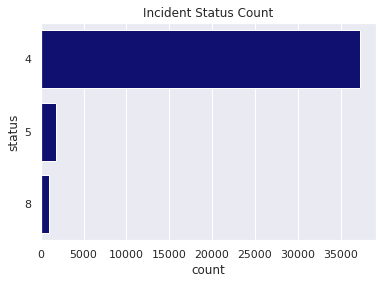

In [22]:
fig = sns.countplot(y="status", data=df, color="navy")
fig.set_title("Incident Status Count")
plt.show()

This shows that by bar most incidents were closed, with some incidents being cancelled (which we'd probably want to keep as the information in them might be still valuable, even if the patient backed out) and some duplicated ones. Since the duplicated ones are duplicates of data, it will skew the results, so I will drop it.
Cleaning the dataset from the "duplicate" calls, to not confound our distribution

In [23]:
print("Number of duplicates: {}".format(sum(df.status == 8)))
# keep only rows with status as not duplicate
df = df[df.status != 8]
print("Now cleaned dataset has {} observations".format(len(df)))

Number of duplicates: 999
Now cleaned dataset has 39021 observations


### Cleaning town IDs
There are two fields related to town data. 
Let's veriry that they correspond uniquely.

In [83]:
town_ids = df[['city', 'city_id']].drop_duplicates()
print("The same town may have different ids:")
#town_ids.city.sort_values()
#(town_ids[town_ids.city.apply(lambda name: name.strip().lower() == "barcelona")][:10])

The same town may have different ids:


In [84]:
towns_by_id = town_ids.groupby('city_id').count().reset_index()
duplicate_ids = towns_by_id[towns_by_id.city > 1].city_id.tolist()
print("Towns sharing ids:")
town_ids[town_ids.city_id.apply(lambda id: id in duplicate_ids)]

Towns sharing ids:


,city,city_id


In [85]:
# remove test row
df = df[df.city != 'CITY PROVES']

### Translate to English

In [31]:
from googletrans import Translator
translator = Translator()
# more complex yet more computationally efficient than tranlsating everything,
# would be to create a dictionary for the unique pathologies and use that to map
# create a list of distinct pathologies
unique_pathologies = df.pathology.unique()
# translate all distinct pathologies 
english_translations = [translator.translate(unique_pathologies[i], dest='en', src='es').text for i in range(len(unique_pathologies))]
for i in range(30):
    print("{} -> {}".format(unique_pathologies[i], english_translations[i]))

laringitis -> laryngitis
curas ulcera -> ulcer cures
cambio de sonda vesical -> change of bladder catheter
curas en cadera -> cures in hip
curas -> cures
fiebre -> fever
asteniameg -> asteniameg
fiebre. dolor garganta. -> fever. throat pain.
inyectable cortisona -> injectable cortisone
inzitan -> inzitan
fortecortin -> fortecortin
cura -> cure
dolor abdominal -> abdominal pain
hipotension -> hypotension
infeccion resp -> infection resp
diarrea -> diarrhea
bronquitis -> bronchitis
viriasis -> viriasis
gripe -> flu
lumbalgia -> low back pain
health consultation -> health consultation
gastroenteritis -> stomach flu
hipertension arterial -> arterial hypertension
amigdalitis -> tonsillitis
mareo -> dizziness
odinofagia -> odynophagia
tos -> cough
astenia -> asthenia
bronquiolitis -> bronchiolitis
catarro -> cold


In [32]:
dict_pathologies = dict(zip(unique_pathologies, english_translations))

# fix some tranlsations
dict_pathologies['acufenostinnitus'] = 'tinnitus'
dict_pathologies['mas moquillos'] = 'canine distemper'
dict_pathologies['migra�a comun'] = 'migraine'
dict_pathologies['imp�tigo'] = 'impetigo'
dict_pathologies['gastroenteritis'] = 'gastroenteritis'
dict_pathologies['otitis'] = 'otalgia' # they mostly overlap: otitis is inflammatory
dict_pathologies['viriasis'] = 'viral infection'
dict_pathologies['ciatalgia'] = 'sciatica'

# make all translation lowercase
dict_pathologies =  {key : value.lower() for key, value in dict_pathologies.items()}
dict_pathologies

{'abuel amigdalitis': 'abuel tonsillitis',
 'accidente vascular cerebral': 'stroke',
 'acufenostinnitus': 'tinnitus',
 'adenopatias': 'adenopathies',
 'aftas': 'canker sores',
 'agitado, no agresivo, nauseas intensas': 'agitated, not aggressive, intense nausea',
 'amenaza aborto': 'abortion threat',
 'amigdalitis': 'tonsillitis',
 'anemia': 'anemia',
 'anginas': 'angina',
 'anorexia': 'anorexy',
 'ansiedad': 'anxiety',
 'artritis': 'arthritis',
 'artropatia temporo-mandibular': 'temporo-mandibular arthropathy',
 'artrosis': 'osteoarthritis',
 'asma bronquial': 'bronchial asthma',
 'asma bronquial exacerbacion': 'bronchial asthma exacerbation',
 'astenia': 'asthenia',
 'asteniameg': 'asteniameg',
 'bnco/epoc': 'bank / epoc',
 'bradicardia': 'bradycardia',
 'bradicardia preferente': 'preferred bradycardia',
 'broncoaspiracion': 'bronchoaspiration',
 'bronquiectasias': 'bronchiectasis',
 'bronquiectasias exacerbacion': 'bronchiectasis exacerbation',
 'bronquiolitis': 'bronchiolitis',
 'br

In [33]:
# add column of new pathologies in English
df['pathology_eng'] = df.pathology.map(dict_pathologies)
# Observe results of tranlsated pathologies
df[['pathology','pathology_eng']].sample(30)

,pathology,pathology_eng
21014,fiebre,fever
17890,fiebre,fever
5044,bronquitis,bronchitis
35450,sinusitis,sinusitis
2604,amigdalitis,tonsillitis
835,amigdalitis,tonsillitis
29892,lumbalgia,low back pain
36228,tos,cough
30470,mareo,dizziness
27563,infeccion respiratoria,respiratory infection


We've just tranlsated all pathologies to English, and on the way consolidated and fixed some pathology values.
Let's convert the "pathology" column to this new translation while saving the spanish translation as a different column

# Mapping incidents
Let's check the location of incidents; first to if all values make sense, and if not, drop the outliers. 

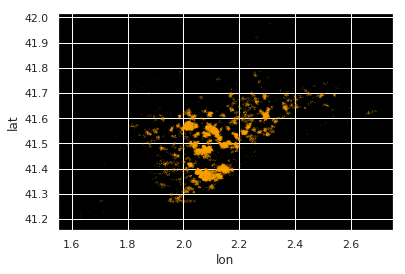

In [86]:
# Check simply according to numerical values of Lat and Lon, which make sense
df.plot(kind='scatter', x='lon', y='lat',
                color='orange', s=0.02, alpha=0.4).set_facecolor('black')

We have 0 geographical outliers (outside of Catalonia...)
Removing them, we have 37628 observations left


<Figure size 1080x576 with 0 Axes>

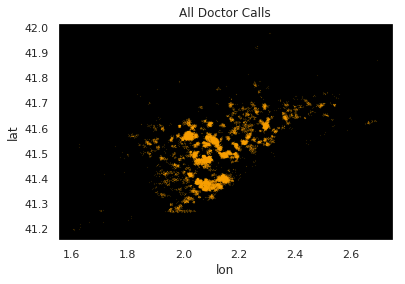

In [87]:
# removing outlier values:
print("We have {} geographical outliers (outside of Catalonia...)".format(len(df[df.lat<30]) + len(df[df.lon<0])))
df = df[(df.lat>41) & (df.lat<42) & (df.lon>1.6) & (df.lon<2.8)] 
print("Removing them, we have {} observations left".format(len(df)))

ax = plt.figure(figsize=(15,8))
ax = df.plot(kind='scatter', x='lon', y='lat',
                color='orange', s=0.02, alpha=0.4)
ax.set_title("All Doctor Calls")
ax.set_facecolor("black")
ax.grid(False)

## Heatmap of total health incident calls

Using folium, a python library working on Leaflet Map using Javascript in the backend to create interactive maps.

In [92]:
import folium
from folium import plugins
from folium.plugins import HeatMap

heatmap = folium.Map(location=[df.lat.mean(),df.lon.mean()], zoom_start = 10) 
HeatMap(df[['lat', 'lon']].values).add_to(heatmap)
heatmap

## Visualizing Date Range

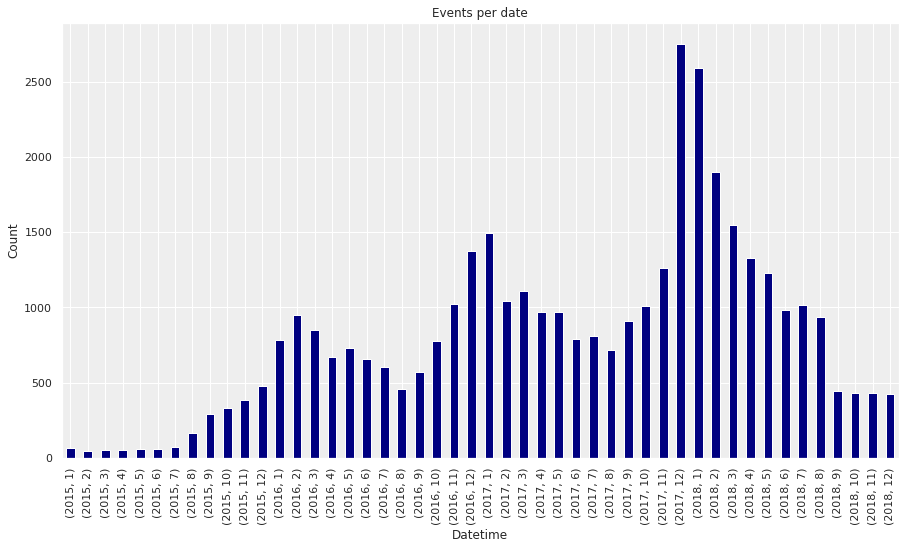

In [41]:
plt.figure(figsize=(15, 8))
ax = df["date"].groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar", color="navy")
ax.set_facecolor('#eeeeee')
ax.set_xlabel("Datetime")
ax.set_ylabel("Count")
ax.set_title("Events per date")
plt.show()

We here observe that our data begins in 2015 (technically in January but really around August), and is updated until the present (Dec 2018), with the highest usage peak in calls being a year ago around Dec 2017 - Jan 2018.

As you can see in the next figure (“Events per date”), there is a clear temporal cyclical pattern going on: there are distinct peaks at winter times and troughs in the summers. Calls increase rapidly between Nov - Jan, and decrease slowly after January until stabilizing in the summer. This seasonality is to be expected for flu and cold season, and weakening of the immune system. This finding is important for decision makers to notice – indeed the population’s health deteriorates in winter and the demand for health services increases. It would therefore be wise to increase staffing and availability of health services in the winter according to those timely cycles, and use proactive measures, from increasing sanitation efforts and awareness leading to that period, to encouraging workers and students to stay home if they are sick with a contagious disease to decrease spread. 


## Visualizing Counts of most common pathologies
Let's check how many cases of the same pathology do we have for the more common pathologies

In [47]:
# prepare value counts list (pathology: number of occurences)
pathology_value_counts = df.pathology_eng.value_counts()

common50 = df.pathology_eng[df.pathology_eng.isin(list(pathology_value_counts[:50].keys()))]
print("Out of {} observations, {} are have the 50 most common diseases ({}% of all)".format(len(df),len(common50),(np.round(len(common50)*100/len(df)))))
common20 = df[df.pathology_eng.isin(list(pathology_value_counts[:20].keys()))]
print("Out of {} observations, {} are have the 20 most common diseases ({}% of all)".format(len(df),len(common20),(np.round(len(common20)*100/len(df)))))
common10 = df[df.pathology_eng.isin(list(pathology_value_counts[:10].keys()))]
print("Out of {} observations, {} are have the 10 most common diseases ({}% of all)".format(len(df),len(common10),(np.round(len(common10)*100/len(df)))))


Out of 38630 observations, 37335 are have the 50 most common diseases (97.0% of all)
Out of 38630 observations, 33056 are have the 20 most common diseases (86.0% of all)
Out of 38630 observations, 25879 are have the 10 most common diseases (67.0% of all)


So, 50 most common diseases cover 97% of all cases. 
20 most common diseases cover 86% of all cases.
10 most common diseases cover 67% of all cases.
Let's focus on the most common 10 then at the moment.

### Print and Visualize the most common diseases

In [48]:
# printing the 50 most common pathologies with their number of reports
pathology_value_counts[:20]

fever                    9563
tonsillitis              3033
gastroenteritis          2067
bronchitis               2028
flu                      1753
low back pain            1665
viral infection          1625
vomiting                 1456
otalgia                  1367
cold                     1322
cough                    1135
abdominal pain           1084
odynophagia               902
dizziness                 822
vertiginous syndrome      798
respiratory infection     655
sciatica                  568
migraine                  450
laryngitis                392
asthenia                  371
Name: pathology_eng, dtype: int64

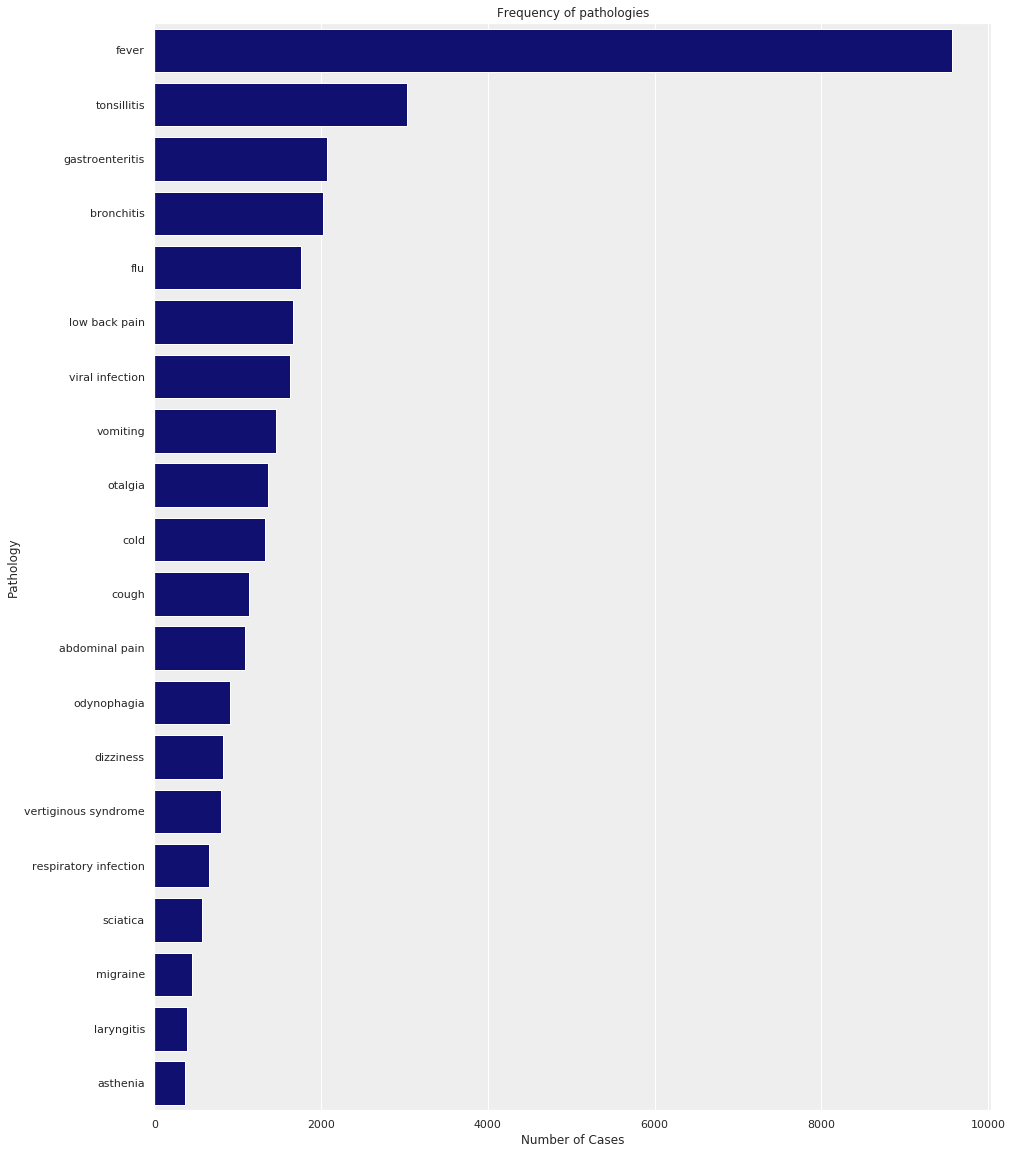

In [89]:
plt.figure(figsize=(15, 20))
ax = sns.countplot(y="pathology_eng", data=common20, color="navy", orient="h", order=common20['pathology_eng'].value_counts().index)
ax.set_facecolor('#eeeeee')
ax.set_xlabel("Number of Cases")
ax.set_ylabel("Pathology")
ax.set_title("Frequency of pathologies")
plt.show()


We see that Fever was by far the most common pathology. However, it is not a disease by itself but rather a symptom, so I will be investigating more into other types of diseases later.

## Map Specific Pathologies in Winter 2018

In [94]:
# First, view only fever, across all time
def heatmap_pathology_time(SELECTED_PATHOLOGY, START_DATE, END_DATE):
    df_formap = df[df.pathology_eng == SELECTED_PATHOLOGY]
    df_formap = df_formap[df_formap.date > pd.to_datetime(START_DATE)]
    df_formap = df_formap[df_formap.date < pd.to_datetime(END_DATE)]
    heatmap_pathology = folium.Map(location=[df.lat.mean(),df.lon.mean()], zoom_start = 11, )
    folium.plugins.HeatMap(df_formap[['lat', 'lon']].values).add_to(heatmap_pathology)
    print("=== {} ===".format(SELECTED_PATHOLOGY.upper()))
    print("Mapping {} {} calls between {} and {}".format(len(df_formap), SELECTED_PATHOLOGY, START_DATE, END_DATE))
    return heatmap_pathology

In [95]:
# Remind us the 10 most common pathologies?
pathology_value_counts[:10]

fever              9563
tonsillitis        3033
gastroenteritis    2067
bronchitis         2028
flu                1753
low back pain      1665
viral infection    1625
vomiting           1456
otalgia            1367
cold               1322
Name: pathology_eng, dtype: int64

stomach flu              2076
bronchitis               2049
flu                      1765

In [96]:
heatmap_pathology_time('tonsillitis', '2017-11-01', '2018-05-01')

=== TONSILLITIS ===
Mapping 826 tonsillitis calls between 2017-11-01 and 2018-05-01


In [98]:
heatmap_pathology_time('gastroenteritis', '2017-11-01', '2018-05-01')

=== GASTROENTERITIS ===
Mapping 519 gastroenteritis calls between 2017-11-01 and 2018-05-01


In [99]:
heatmap_pathology_time('bronchitis', '2017-11-01', '2018-05-01')

=== BRONCHITIS ===
Mapping 654 bronchitis calls between 2017-11-01 and 2018-05-01


In [100]:
heatmap_pathology_time('flu', '2017-11-01', '2018-05-01')

=== FLU ===
Mapping 747 flu calls between 2017-11-01 and 2018-05-01


# Time Based Interactive HeatMap of Pathologies
Let's see how calls for a pathology travel in time and space!
I'll focus on the (overwhelmingly) most common pathology, Firbre = fever.
Focusing on the latest disease season: 2017-11 to 2018-05.

In [66]:
import folium.plugins

SELECTED_PATHOLOGY = 'tonsillitis'
START_DATE = '2017-11-01'
END_DATE = '2018-05-01'

map_time = folium.Map(location=[df.lat.mean(),df.lon.mean()],
                    zoom_start = 10) 
# (ensure you're dealing with floats. I did: type(df.lat[0]==numpy.float64))

# Reduce the DF, select only one pathology between specific dates
heat_df = df[df.pathology_eng == SELECTED_PATHOLOGY]
heat_df = heat_df[heat_df.date > pd.to_datetime(START_DATE)]
heat_df = heat_df[heat_df.date < pd.to_datetime(END_DATE)]
heat_df = heat_df.sort_values(by='date')
heat_df["date_day"] = df.date.dt.date # reduce hour to just date

#print(heat_df)
# List comprehension to make out list of lists
#heat_data = [[[row['lat'],row['lon']] for index, row in heat_df[heat_df['date_day'] == i].iterrows()] for i in range(0,365)]
heat_data = heat_df[['lat','lon']]
# Plot it on the map
hm = folium.plugins.HeatMapWithTime(
    heat_data,
    index=heat_df.date_day,
    auto_play=True,
    max_opacity=0.7)
hm.add_to(map_time)
# Display the map
map_time

# Inference through modeling: Does Geography inform Pathology type?
## Predictive Classification Algorithms

### Data Preprocessing for Machine Learning Modeling
To explore wether geography correlates with pathology type, in comparison with other available informaiton about the patient.
Currently, all the relevant information for prediction of pathology type in a call would be:
1. Age of patient
2. Number of calls/visits (through counting appearances of id_personal)
3. Date (which I can divide into date, year, month, week, day/is_weekend, to add granularity)
4. Geographical variables: Latitute, Longitude, Zip, City_Id

Since we'd want a classification model, we better focus on the most common diseases (for which there is enough information, and so to not have too many possible groups for classification).

#### Preparing Variables

In [67]:
# Predict the pathology given all other info: with location or not?
# Predict the # of cases per day, given location or not? (of a specific disease?)
# Predict 

In [68]:
## Clean more data for prediction
df.describe()

,status,time_delay,city_id,age,zip,lat,lon,id_type,id_personal,n_visits,minor_18
count,38630.000000,38630.000000,38630.000000,38630.000000,38630.000000,38630.000000,38630.000000,38630.0,38630.000000,38630.0,38630.000000
mean,4.046492,68.871214,69.375408,32.681129,8377.411830,41.498914,2.108648,1.0,54.944887,1.0,1.647140
std,0.210552,39.898329,51.038349,26.241106,310.777311,0.093776,0.102496,0.0,19.132203,0.0,0.477866
min,4.000000,0.000000,1.000000,-5.000000,8004.000000,41.194922,1.605335,1.0,0.000000,1.0,1.000000
25%,4.000000,45.000000,26.000000,8.000000,8186.000000,41.403542,2.046464,1.0,45.000000,1.0,1.000000
50%,4.000000,60.000000,50.000000,32.000000,8222.000000,41.501779,2.089283,1.0,55.000000,1.0,2.000000
75%,4.000000,90.000000,114.000000,50.000000,8520.000000,41.566505,2.146895,1.0,68.000000,1.0,2.000000
max,5.000000,150.000000,194.000000,106.000000,8990.000000,41.978100,2.696063,1.0,102.000000,1.0,2.000000


In [69]:
# df['id_type'].describe()
# ID Type was 1.0 for everyone. that doesn't add any information
df['id_type'] = None

# n_visits is also not adding any info and just confounding
df['n_visits'] = None

# len(df[df.age==0])
# We have 1010 observations without age 
# (age of 0.0, many of them marked as not a "Minor", so must be a mistake.)
# drop them:
df = df[df.age>0]

In [70]:
# Add more variables for prediction - non geographical
# 1. Age
# 2. We have ID, but what we really want to know is how many times did they call? 
# since we don't want the ID itself to be taken as a continuous variable
# add the number of visits as a variable
# df.id_personal.value_counts()
df['visits'] = df.groupby('id_personal')['id_personal'].transform('count')

In [71]:
# make date into numerical value
import datetime as dt

df['dayofyear'] = df.date.dt.dayofyear
df['month'] = df.date.dt.month
df['dayofmonth'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['hour'] = df.date.dt.hour

#df['date_numerical'] 
df['date_numerical'] = df['date'].map(dt.datetime.toordinal)

#### Standartization

In [72]:
# Standardization, or mean removal and variance scaling. This is crucial to improve fit of the model

In [73]:
import sklearn
from sklearn import preprocessing
df['x_age_scaled'] = preprocessing.scale(df[['age']])
df['x_visits'] = preprocessing.scale(df[['visits']])
df['x_date'] = preprocessing.scale(df[['date_numerical']])
df['x_month'] = preprocessing.scale(df[['month']])
df['x_dayofweek'] = preprocessing.scale(df[['dayofweek']])
df['x_hour'] = preprocessing.scale(df[['hour']])

df['x_lon'] = preprocessing.scale(df[['lon']])
df['x_lat'] = preprocessing.scale(df[['lat']])
df['x_zip'] = preprocessing.scale(df[['zip']])

## TODO: Later I will add:
## Polynomial Features, 
## Maybe External Variables like climate

/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  import sys
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [74]:
# Dummy variable groups for Y
df['pathology_id'] = df['pathology_eng'].astype('category').cat.codes
df[['pathology_eng','pathology_id']].sample(30)

,pathology_eng,pathology_id
15450,fever,88
27774,respiratory infection,181
4994,bronchitis,32
34572,vertiginous syndrome,214
21439,fever,88
28635,laryngitis,127
15016,fever,88
2034,tonsillitis,203
31572,migraine,138
21305,fever,88


In [75]:
dict_pathology_codes = dict( enumerate(df['pathology_eng'].astype('category').cat.categories) )
print(dict_pathology_codes[88], dict_pathology_codes[203])

fever tonsillitis


#### Subset data to 10 most common diseases, divide into train and test sets

In [78]:
from sklearn.model_selection import train_test_split

# Subset data to 10 most common diseases
df_model = df[df.pathology_eng.isin(list(pathology_value_counts[:10].keys()))]

# Select relevant columns
xvars_nongeo = ['x_age_scaled','x_visits','x_date','x_month','x_dayofweek','x_hour']
xvars_geo = ['x_lon','x_lat','x_zip']
xvars_all = xvars_nongeo + xvars_geo
vars_all = xvars_all + ['patholody_id']
print(vars_all)
X_df = df_model[xvars_all]

# divide into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_df, df_model['pathology_id'], test_size=0.2, random_state=100)
print("\nDivided into train set of {} observations and test set of {} observations".format(
    len(X_train),len(X_test)))

['x_age_scaled', 'x_visits', 'x_date', 'x_month', 'x_dayofweek', 'x_hour', 'x_lon', 'x_lat', 'x_zip', 'patholody_id']

Divided into train set of 20136 observations and test set of 5035 observations


In [79]:
# Save datasets to disk for backup
df_model.to_csv('./output/df_urbanhealth_model_10common.csv')
df.to_csv('./output/df_urbanhealth.csv')

# Classifiers
Here I've chosen classifiers for this task based on their flexibility, performance, and interpretability (of trees). 
For more details about classifiers comparison, refer to [Scikit-Learn Comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py).

### Decision Tree Classifier
A Decision tree classifier learns deterministic decision boundaries using the given features to classify observations. The more the tree uses some feature, the more "meaningful", or relevant information for classification, that feature contains. Thus, we can view the importance plot of features by the decision tree as a ranking of "relevance" of the given features of the classification task at hand.
Therefore, a decision tree run on both geographical and non-geographical features could tell us what is their order of importance.
A decision tree is a fairly robust and well-regarded method for multiclass classification. Therefore, we can create seperate models with or without geographical data and observe their performance, as a matter of telling how much relevant information for classification is contained in the geographical features compared to non-geographical information; or if there is predicting power to geographical information alone!

Accuracy: 0.247 +/- 0.01


/Users/tomer/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


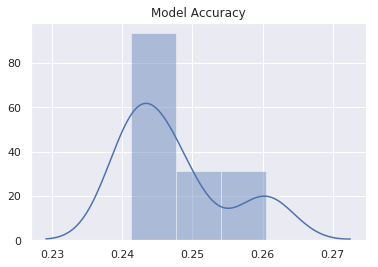

In [80]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

# Classifier with ALL variables: both Geo and Non-Geo
clf = tree.DecisionTreeClassifier(max_depth=30)
# Cross validate fit and prediction score
scores = np.array(cross_val_score(clf, X_train[xvars_all], y_train, scoring='accuracy', cv=5))
print("Accuracy: {:.3f} +/- {:.2f}".format(scores.mean(),scores.std()))

sns.distplot(scores).set_title("Model Accuracy")
plt.show()

So, our Decision Tree classifier didn't do very well even with all available parameters. That is reasonable, since these parameters wouldn't intuitively suggest a pathology type: information about the patient's age, the date-time and location of the call is all we have. That is reasonably not sufficient information for prediction of pathology type.

However, I shall go in two ways around this:
1. Try more flexible and stronger ML models that might take advantage of the existing data better and achieve better results, and
2. Look for external variables to add which might be better correlated with health performance


If those would be unsuccessful, I could resort to the following simpler prediction task:
3. Resort to prediction of amount of calls based on location or not.

This will not tell us about underlying differences between diseases and areas (what disease is correlated with which area), but are there areas that are likelier to call at specific times and conditions.

### Random Forest Classifier
Random Forest is basically a "forest" of decision trees. It is a meta-estimator, which first many decision tree classifiers on different subsamples of the dataset, and uses averaging to make the decision boundaries more accurate, granular, and flexible than a single decision tree, while controlling for overfitting. 



Accuracy: 0.362 +/- 0.0038


/Users/tomer/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


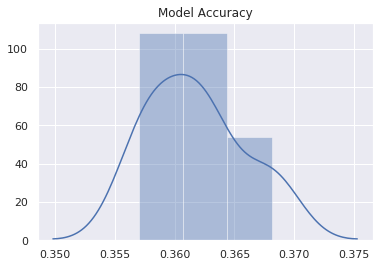

In [81]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Classifier with ALL variables: both Geo and Non-Geo
clf = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=9)
clf.fit(X_train[xvars_all], y_train)
# Cross validate fit and prediction score
scores = np.array(cross_val_score(clf, X_train[xvars_all], y_train, scoring='accuracy', cv=5))
print("Accuracy: {:.3f} +/- {:.4f}".format(scores.mean(),scores.std()))

sns.distplot(scores).set_title("Model Accuracy")
plt.show()

Our Random forest indeed perform better than our single decision tree – which makes sense, and tells that indeed the data could be used better than the simple decision tree did, and might benefit from more flexible function fitting than the simple collection of linear of decision boundaries resulting from a single tree. 
We can therefore inspect the importance of the features our classifier used, to tell how relevant was the information contained in each!

### Evaluating Classifier Performance
Predicting disease type, checking class balance and accuracy

In [595]:
def y_class_dist_df(y):
    y_valuecounts = y.value_counts()
    y_vals_df = pd.DataFrame([y_valuecounts.keys(), y_valuecounts.values])
    y_vals_df = y_vals_df.T
    y_vals_df.columns = ["code","freq"]
    y_vals_df['pathology'] = y_vals_df.code.map(dict_pathology_codes)
    y_vals_df = y_vals_df[['pathology','code','freq']]
    total = y_vals_df.freq.sum()
    y_vals_df['percent'] = y_vals_df.freq / total
    return y_vals_df

In [596]:
y_test_vals_df = y_class_dist_df(y_test)
y_test_vals_df

,pathology,code,freq,percent
0,fever,88,1889,0.375174
1,tonsillitis,203,610,0.121152
2,gastroenteritis,95,426,0.084608
3,bronchitis,32,392,0.077855
4,flu,90,327,0.064945
5,low back pain,133,314,0.062363
6,viral infection,216,303,0.060179
7,vomiting,219,289,0.057398
8,otalgia,152,272,0.054022
9,cold,47,213,0.042304


<BarContainer object of 10 artists>

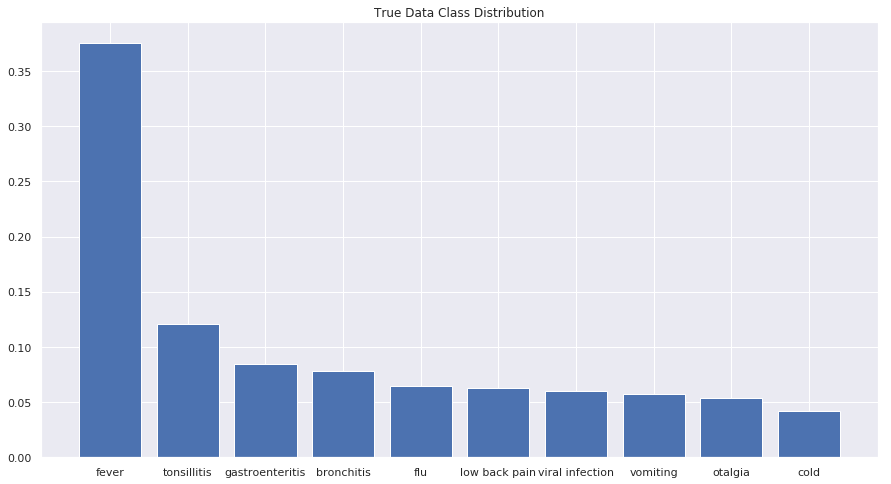

In [597]:
plt.figure(figsize=(15,8))
plt.title("True Data Class Distribution")
plt.bar(y_train_vals_df.pathology, y_train_vals_df.percent) 

##### What's the baseline?
So, currently, our most common class is ~36% of data, so a dumb model could achieve 36% accuracy predicting only this class. Did the model do that?
##### What's the distribution of Y in our data, and distribution of predicted y?

In [599]:
y_pred = fit.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred_vals_df = y_class_dist_df(y_pred)
y_pred_vals_df

,pathology,code,freq,percent
0,fever,88,1735,0.344588
1,tonsillitis,203,647,0.128500
2,bronchitis,32,416,0.082622
3,gastroenteritis,95,415,0.082423
4,flu,90,355,0.070506
5,viral infection,216,321,0.063754
6,low back pain,133,311,0.061768
7,otalgia,152,288,0.057200
8,cold,47,279,0.055412
9,vomiting,219,268,0.053227


<BarContainer object of 10 artists>

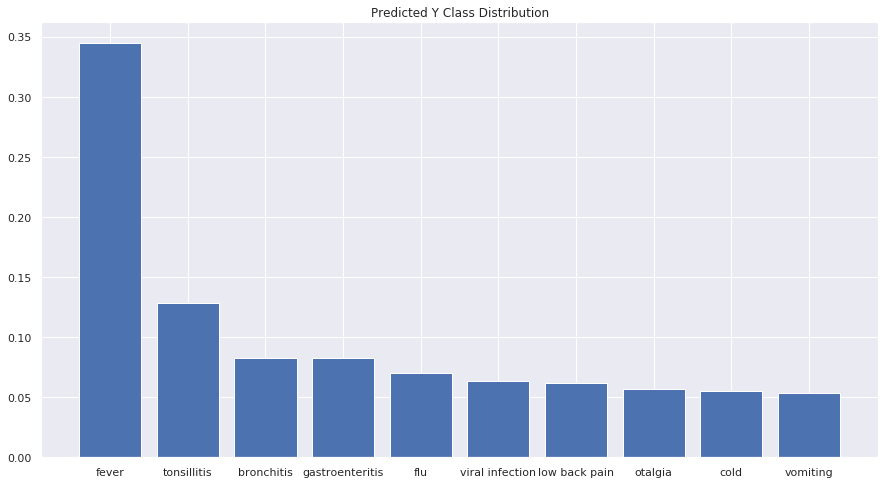

In [600]:
# y_pred = fit.predict(X_test)
# y_pred = pd.Series(y_pred)
# y_pred_vals_df = y_class_dist_df(y_pred)
# y_pred_vals_df
plt.figure(figsize=(15,8))
plt.title("Predicted Y Class Distribution")
plt.bar(y_pred_vals_df.pathology, y_pred_vals_df.percent) 

#### Evaluating Model Performance:
Checking class balance, and Classification Report

In [601]:
# AREA UNDER THE ROC CURVE
from sklearn.metrics import roc_auc_score

# Predict class probabilities - needed for AUROC score
prob_y_2 = clf.predict_proba(X_test)
#pd.DataFrame(prob_y_2)
# Keep only the positive class
# prob_y_2 = 

In [602]:
# map names of classes
classnames_sorted = y_test_vals_df.sort_values(by='code')
classnames_sorted = np.array(classnames_sorted['pathology'])
classnames_sorted

array(['bronchitis', 'cold', 'fever', 'flu', 'gastroenteritis',
       'low back pain', 'otalgia', 'tonsillitis', 'viral infection',
       'vomiting'], dtype=object)

In [603]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.14      0.15      0.14       392
           cold       0.07      0.09      0.08       213
          fever       0.44      0.40      0.42      1889
            flu       0.17      0.19      0.18       327
gastroenteritis       0.16      0.16      0.16       426
  low back pain       0.23      0.22      0.22       314
        otalgia       0.14      0.14      0.14       272
    tonsillitis       0.20      0.21      0.20       610
viral infection       0.11      0.11      0.11       303
       vomiting       0.10      0.09      0.10       289

      micro avg       0.25      0.25      0.25      5035
      macro avg       0.18      0.18      0.18      5035
   weighted avg       0.26      0.25      0.26      5035



So, the Random Forest did not perform well, with percision and recall of betwen 0.1-0.2 for most classes, except for 0.4 for "fever", the most common class (by far).

### Interpreting feature importance: which variables were most important for prediction of pathology type?

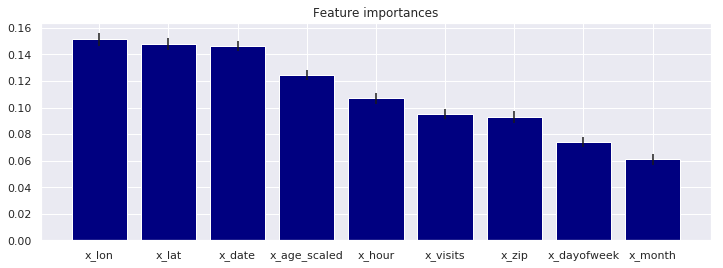

,Variable,Importance
0,x_lon,0.151
1,x_lat,0.148
2,x_date,0.146
3,x_age_scaled,0.124
4,x_hour,0.107
5,x_visits,0.095
6,x_zip,0.093
7,x_dayofweek,0.074
8,x_month,0.061


In [604]:
def feature_importance_plot(classifier_model):
    global xvars_all 
    xvars_all = np.array(xvars_all)
    importances = classifier_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier_model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Display the feature ranking
    feature_ranks = pd.DataFrame([xvars_all[indices], np.round(importances[indices],3)]).T
    feature_ranks.columns = ['Variable','Importance']

    # Plot the feature importances of the forest
    plt.figure(figsize=(12,4))
    plt.title("Feature importances")
    plt.bar(xvars_all[indices], importances[indices],
           color="navy", yerr=std[indices], align="center")
    plt.show()
    
    return feature_ranks #display the data of feature importance

feature_importance_plot(clf)

So in fact, the **most relevant information** was found in the **geographical variables of Longitude and Latitude**!
That's an exciting finding.
Out of all of these variables, the model saw Lat and Lon as the most relevant for prediction of the type of disease.

However, the model didn't perform all that well in accuracy of prediction (percision / recall, as you can see in the confusion matrix). 

#### How can we improve this?

One problem is that the classes aren't balanced. We have mostly cases of 'fever' rather than anything else, which biases our predictions and skews our outcomes. 
I will balance our classes and see the model's performance on that.

##### Downsampling The dominating class label: "fever"

In [565]:
df_model_balance = df_model
print("DF Size: ", len(df_model))
median_class_freq = df_model_balance.pathology_id.value_counts().median()
print("\nValue Counts:\n",df_model_balance.pathology_id.value_counts())
df_model_balance_fever = df_model[df_model.pathology_id==88]
df_model_balance_allothers = df_model[df_model.pathology_id!=88]
print("\nDivided into fever and not: ", len(df_model_balance_fever),len(df_model_balance_allothers))

## Downsample majority class, to be of the median* class size 
# *(slightly biased upwards since median was calculated including big fever class)
df_fever_downsampled = df_model_balance_fever.sample(frac=median_class_freq/len(df_model_balance_fever))
print("Now downsampled class to ", len(df_fever_downsampled))

# Recombine datasets
df_model_balance = pd.concat([df_model_balance_allothers, df_fever_downsampled])
df_model_balance = df_model_balance.sample(frac=1) # reshuffle rows so not all new ones are at end
print("Now, after downsampling and combining back, here are our class value counts")
print(df_model_balance.pathology_id.value_counts())

DF Size:  25171

Value Counts:
 88     9208
203    3016
95     2043
32     1968
90     1727
133    1659
216    1575
219    1425
152    1328
47     1222
Name: pathology_id, dtype: int64

Divided into fever and not:  9208 15963
Now downsampled class to  1693
Now, after downsampling and combining back, here are our class value counts
203    3016
95     2043
32     1968
90     1727
88     1693
133    1659
216    1575
219    1425
152    1328
47     1222
Name: pathology_id, dtype: int64


In [616]:
# Now we will redivide our train and test sets from the more balanced data.
X_train, X_test, y_train, y_test = train_test_split(
    df_model_balance[xvars_all], df_model_balance['pathology_id'], test_size=0.2, random_state=100)
print("\nDivided into train set of {} observations and test set of {} observations".format(
    len(X_train),len(X_test)))
df_model_balance[xvars_all].sample(2)


Divided into train set of 14124 observations and test set of 3532 observations


,x_age_scaled,x_visits,x_date,x_month,x_dayofweek,x_hour,x_lon,x_lat,x_zip
24842,-0.213252,-0.507638,0.979742,-0.594836,1.440029,-1.054756,0.729777,0.416589,-0.795124
24804,0.209293,1.210445,1.213354,0.192744,-0.500640,1.341439,0.499693,-1.097008,-1.187193


<BarContainer object of 10 artists>

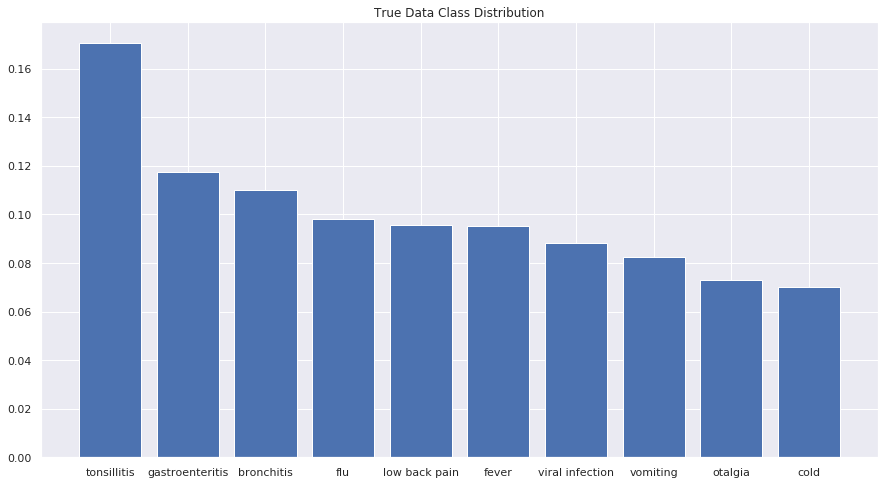

In [617]:
# View balance of true data classes
y_test_vals_df = y_class_dist_df(y_test)
y_test_vals_df
plt.figure(figsize=(15,8))
plt.title("True Data Class Distribution")
plt.bar(y_test_vals_df.pathology, y_test_vals_df.percent) 

Not perfect, but much more balanced; without losing too much information or manipulating rows (e.g., upsampling which would be duplicating rows) from any other class.
I will try again the random forest and see if we have any improvement.

Accuracy is misleading, especially in imbalanced classes: the model could have learned to always predict "fever" which would give it a 35% accuracy that it had (although it wasn't doing that). We prefer to look at the confusion matrix for our own information.

Accuracy: 0.259 +/- 0.0067


/Users/tomer/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


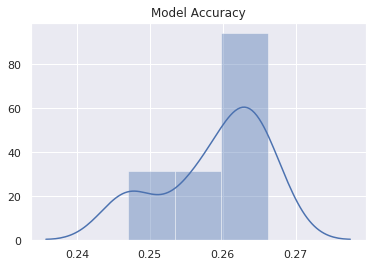

In [572]:
# (More) Balanced Data
# Classifier with ALL variables: both Geo and Non-Geo
clf = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=9)
clf.fit(X_train, y_train)

# # Cross validate fit and prediction score
# scores = np.array(cross_val_score(clf, X_train[xvars_all], y_train, scoring='accuracy', cv=5))
# print("Accuracy: {:.3f} +/- {:.4f}".format(scores.mean(),scores.std()))

# sns.distplot(scores).set_title("Model Accuracy")
# plt.show()

<BarContainer object of 10 artists>

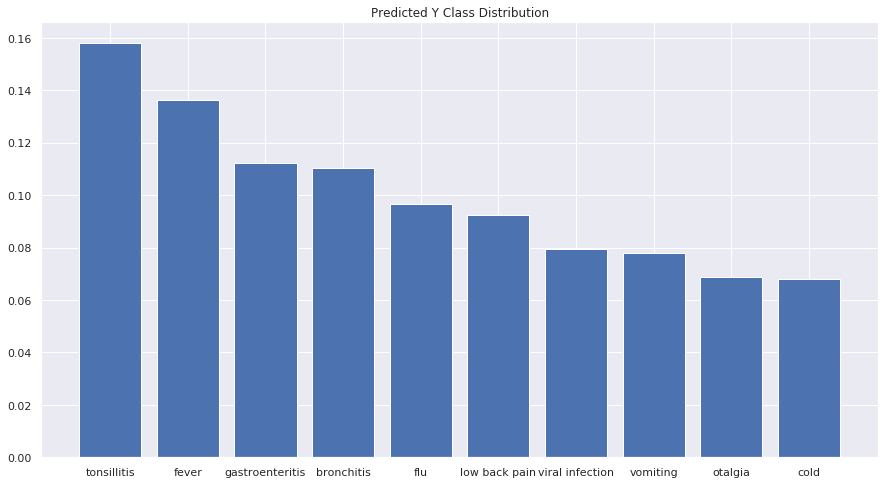

In [573]:
y_pred = fit.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred_vals_df = y_class_dist_df(y_pred)
y_pred_vals_df
plt.figure(figsize=(15,8))
plt.title("Predicted Y Class Distribution")
plt.bar(y_pred_vals_df.pathology, y_pred_vals_df.percent) 

### Classification Report – Confusion matrix and averages of percision and recall

In [579]:
print(classification_report(y_test, y_pred, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.86      0.86      0.86       388
           cold       0.84      0.81      0.83       247
          fever       0.63      0.90      0.74       336
            flu       0.87      0.86      0.86       347
gastroenteritis       0.88      0.84      0.86       414
  low back pain       0.89      0.86      0.88       338
        otalgia       0.89      0.84      0.87       258
    tonsillitis       0.89      0.82      0.85       602
viral infection       0.92      0.83      0.87       311
       vomiting       0.89      0.84      0.86       291

      micro avg       0.85      0.85      0.85      3532
      macro avg       0.85      0.85      0.85      3532
   weighted avg       0.86      0.85      0.85      3532



The model's performance has improved wildly! Now our precision and recall have improved drastically from ~0.2 to 0.85. 
Precision and recall are measures related to accuracy: precision is the percentage of positive predictions which are true, and recall is how many of all positive cases have we classified as such). 

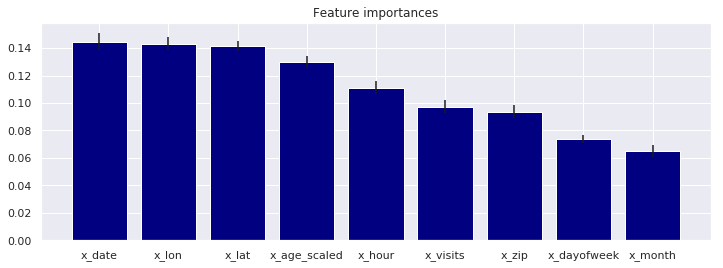

,Variable,Importance
0,x_date,0.145
1,x_lon,0.143
2,x_lat,0.141
3,x_age_scaled,0.13
4,x_hour,0.111
5,x_visits,0.097
6,x_zip,0.094
7,x_dayofweek,0.074
8,x_month,0.065


In [589]:
feature_importance_plot(clf)

**Now, our model's performance has improved drastically to precision / recall values around ~0.85(!), suggesting that it is sufficiently accurate to start taking it seriously. Looking at the importance plot, we see that still, Latitude and Longitude are of importance number #2 and #3, overshot only by a little bit by one variable - date; yet those are two variables to they basically account for twice that relevance when taken together!**

##### Therefore, this suggests that Geographical variables / information ARE relevant to predict the type of pathology, therefore suggesting that geography is correlated and contains important information related to types of pathologies.

### Model without geographical parameters
Let's see how the model will do without geographical parameters.

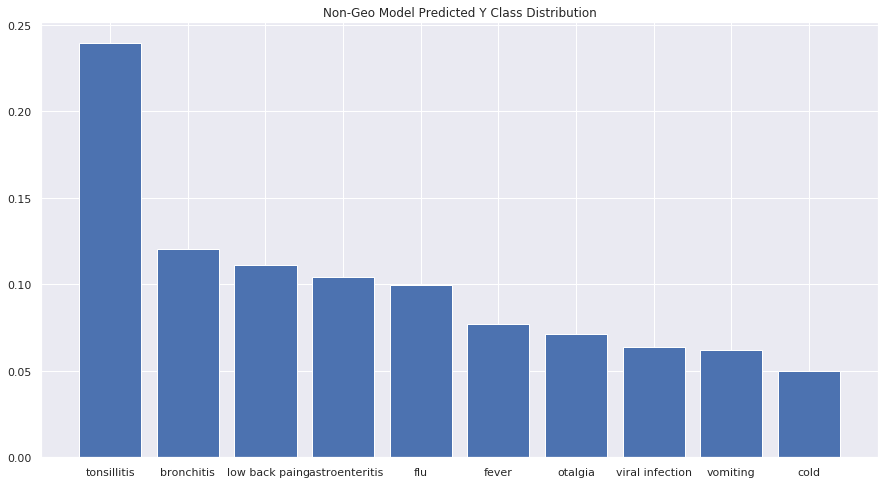

In [618]:
# (More) Balanced Data
# Classifier with only Non-Geo variables
clf_nongeo = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=len(xvars_nongeo))
clf_nongeo.fit(X_train[xvars_nongeo], y_train)

y_pred_nongeo = clf_nongeo.predict(X_test[xvars_nongeo])
y_pred_nongeo = pd.Series(y_pred_nongeo)
y_pred_nongeo_vals_df = y_class_dist_df(y_pred_nongeo)
y_pred_nongeo_vals_df
plt.figure(figsize=(15,8))
plt.title("Non-Geo Model Predicted Y Class Distribution")
plt.bar(y_pred_nongeo_vals_df.pathology, y_pred_nongeo_vals_df.percent) 
plt.show()

In [620]:
print(classification_report(y_test, y_pred_nongeo, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.23      0.26      0.24       388
           cold       0.20      0.14      0.17       247
          fever       0.17      0.14      0.15       336
            flu       0.31      0.31      0.31       347
gastroenteritis       0.23      0.21      0.22       414
  low back pain       0.31      0.36      0.33       338
        otalgia       0.24      0.24      0.24       258
    tonsillitis       0.30      0.42      0.35       602
viral infection       0.19      0.14      0.16       311
       vomiting       0.23      0.17      0.20       291

      micro avg       0.26      0.26      0.26      3532
      macro avg       0.24      0.24      0.24      3532
   weighted avg       0.25      0.26      0.25      3532



We see that the non-geographical model performed quite poorly relatively to the model with geographical information (~0.2 vs 0.85 in average precition and recall).
Let's check how would a model with *only* geographical information will do

### Model with only geographical data

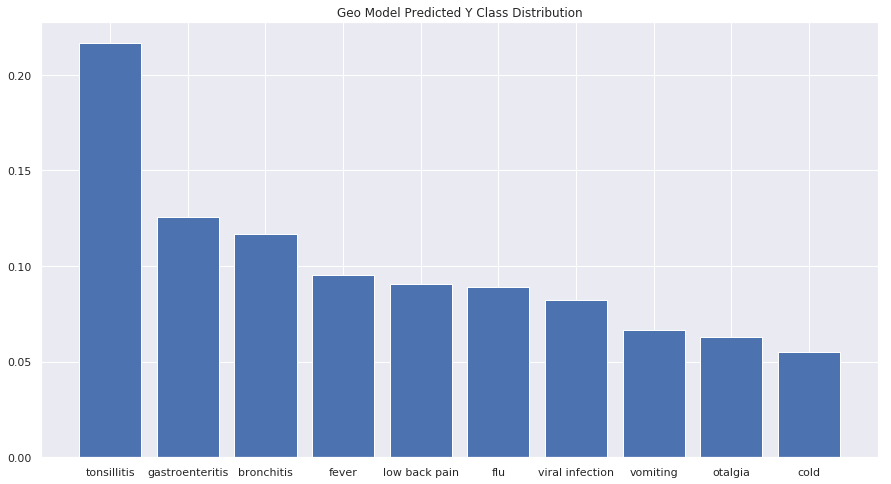

In [621]:
# (More) Balanced Data
# Classifier with only Geo variables
clf_geo = RandomForestClassifier(max_depth=30, n_estimators=30, max_features=len(xvars_geo))
clf_geo.fit(X_train[xvars_geo], y_train)

y_pred_geo = clf_geo.predict(X_test[xvars_geo])
y_pred_geo = pd.Series(y_pred_geo)
y_pred_geo_vals_df = y_class_dist_df(y_pred_geo)
y_pred_geo_vals_df
plt.figure(figsize=(15,8))
plt.title("Geo Model Predicted Y Class Distribution")
plt.bar(y_pred_geo_vals_df.pathology, y_pred_geo_vals_df.percent) 
plt.show()

In [622]:
print(classification_report(y_test, y_pred_geo, target_names=classnames_sorted))

                 precision    recall  f1-score   support

     bronchitis       0.16      0.17      0.16       388
           cold       0.10      0.08      0.09       247
          fever       0.09      0.09      0.09       336
            flu       0.13      0.12      0.13       347
gastroenteritis       0.12      0.13      0.12       414
  low back pain       0.14      0.13      0.14       338
        otalgia       0.13      0.11      0.12       258
    tonsillitis       0.18      0.23      0.20       602
viral infection       0.14      0.13      0.13       311
       vomiting       0.09      0.08      0.08       291

      micro avg       0.14      0.14      0.14      3532
      macro avg       0.13      0.13      0.13      3532
   weighted avg       0.13      0.14      0.14      3532



It seems that overall, our non-geographical variables contained more relevant information than the geographical variabels when it comes to predicting the pathology type from them: with precision and recall averages of ~0.25 vs ~0.14 respectively. 
However, it is only when we combined them together that we achieved drastically (nonlinearly) better results: with an impressive ~0.85 score for precision and recall!


**This suggest that we shuold continue to combine our datasets with geospatial information, in order to get much better information for making predictions and conclusions.**
